In [1]:
from pysheds.grid import Grid
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load data

In [2]:
grid = Grid.from_raster('/Users/mdbartos/Data/Shoalcreek.tiff', data_name='dem')

In [3]:
grid.mask = np.where(grid.dem == grid.dem.nodata, False, True)

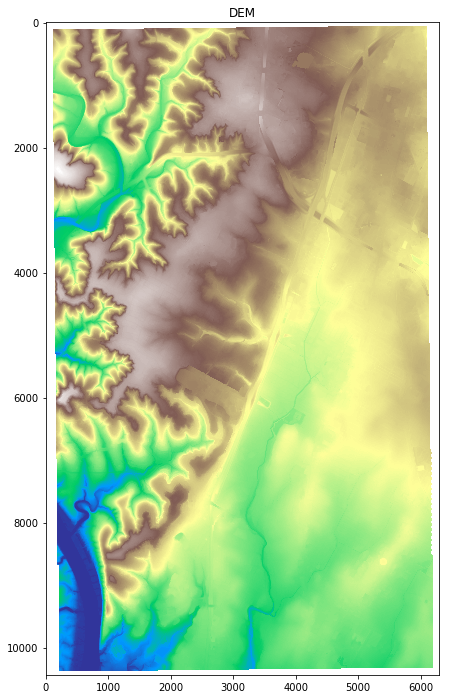

In [4]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(grid.view('dem', nodata=np.nan), cmap='terrain')
_ = plt.title('DEM')

In [5]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
dem = grid.dem

# Run hydro functions

In [16]:
%time pit_filled_dem = grid.fill_pits(dem, inplace=False)

CPU times: user 2.24 s, sys: 902 ms, total: 3.14 s
Wall time: 2.34 s


In [17]:
%time flooded_dem = grid.fill_depressions(pit_filled_dem, inplace=False)

CPU times: user 1min 1s, sys: 13.5 s, total: 1min 14s
Wall time: 1min 21s


In [18]:
%time inflated_dem = grid.resolve_flats(flooded_dem, eps=1e-13, inplace=False)

CPU times: user 18.7 s, sys: 2.13 s, total: 20.8 s
Wall time: 13.1 s


In [26]:
%time fdir_d8 = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=0, routing='d8', pits=-2, flats=-1, inplace=False)

CPU times: user 4.07 s, sys: 1.71 s, total: 5.78 s
Wall time: 3.48 s


In [27]:
%time fdir_dinf = grid.flowdir(inflated_dem, dirmap=dirmap, routing='dinf', inplace=False)

CPU times: user 1min, sys: 924 ms, total: 1min 1s
Wall time: 17.3 s


In [21]:
%time acc_d8 = grid.accumulation(fdir_d8, dirmap=dirmap, routing='d8', inplace=False)

CPU times: user 8.67 s, sys: 3.35 s, total: 12 s
Wall time: 13.2 s


In [22]:
%time acc_dinf = grid.accumulation(fdir_dinf, dirmap=dirmap, routing='dinf', inplace=False)

CPU times: user 22.1 s, sys: 9.85 s, total: 32 s
Wall time: 31.8 s


In [23]:
%time channels_d8 = grid.extract_river_network(fdir_d8, acc_d8 > 100000, routing='d8')

CPU times: user 4.04 s, sys: 2.61 s, total: 6.65 s
Wall time: 5.18 s


In [24]:
%time hand_d8 = grid.compute_hand(fdir_d8, dem, acc_d8 > 10000, routing='d8', inplace=False)

CPU times: user 16 s, sys: 3.64 s, total: 19.7 s
Wall time: 19 s


In [25]:
%time hand_dinf = grid.compute_hand(fdir_dinf, dem, acc_dinf > 10000, routing='dinf', inplace=False)

CPU times: user 20.5 s, sys: 5.91 s, total: 26.4 s
Wall time: 24.9 s


# Total accumulation

In [28]:
acc_d8.max()

Raster(26292691)

In [29]:
acc_dinf.max()

Raster(26285744.18369312)

# Extracted channel network

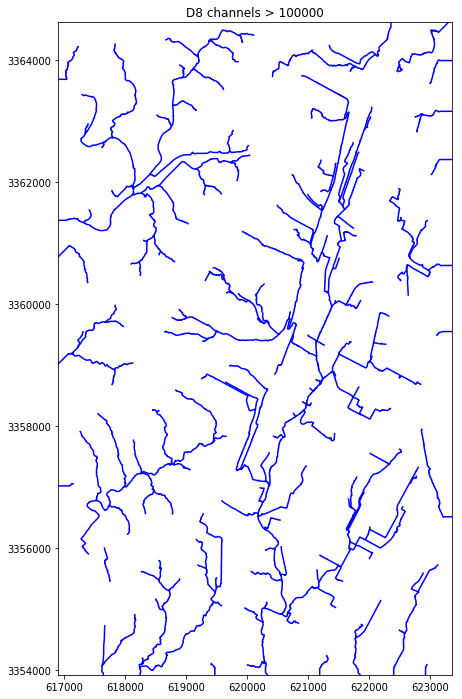

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in channels_d8['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], c='b')
    
_ = plt.title('D8 channels > 100000')

# Example HAND indundation

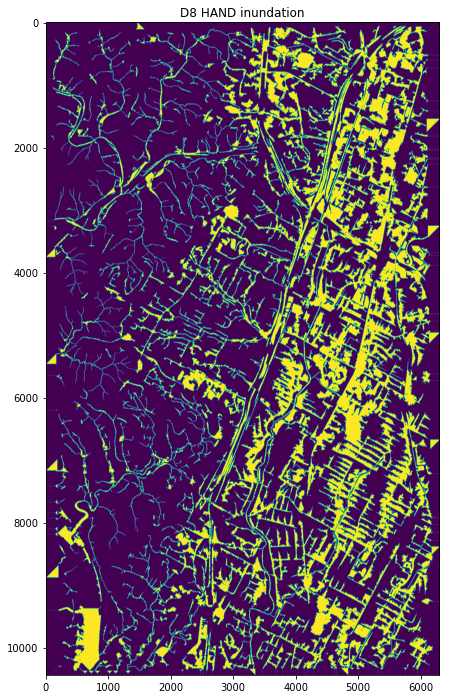

In [31]:
fig, ax = plt.subplots(figsize=(12,12))

plt.imshow(hand_d8 < 1, interpolation='bilinear')
_ = plt.title('D8 HAND inundation')

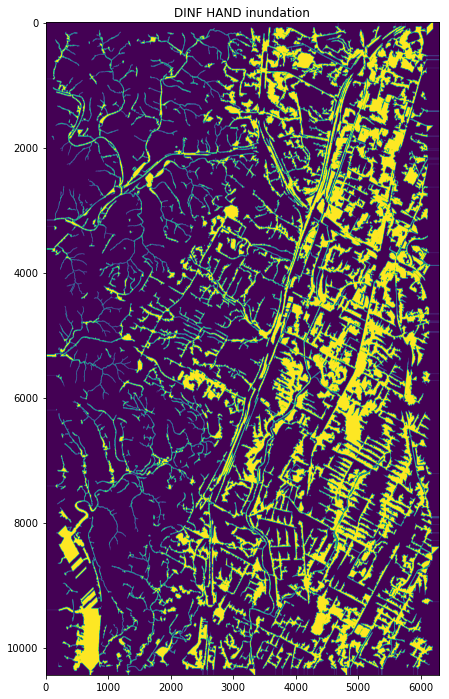

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(hand_dinf < 1, interpolation='bilinear')
_ = plt.title('DINF HAND inundation')

# Some flats were not resolved

In [33]:
# Flats
(fdir_d8 == -1).sum()

Raster(2100)

In [34]:
# Pits
(fdir_d8 == -2).sum()

Raster(25)

Text(0.5, 1.0, 'Unresolved flats')

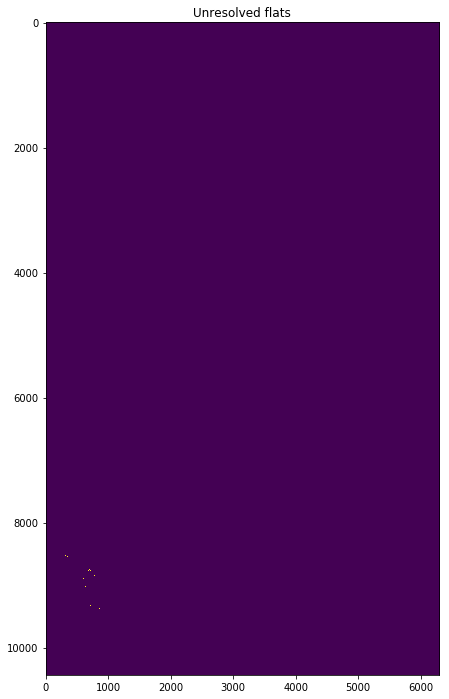

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(fdir_d8 == -1)
plt.title('Unresolved flats')

# Flats occur on river due to lack of depth resolution

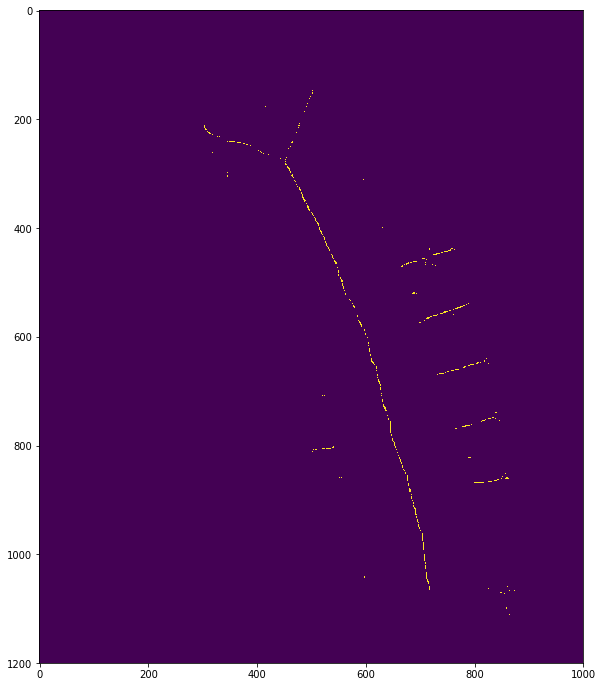

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow((fdir_d8 == -1)[8300:9500, 0:1000])

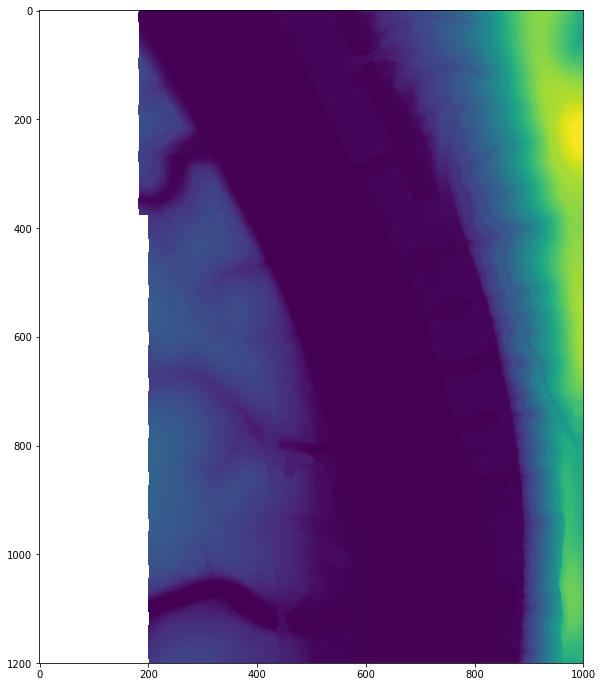

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow((np.where(dem != dem.nodata, dem, np.nan))[8300:9500, 0:1000])